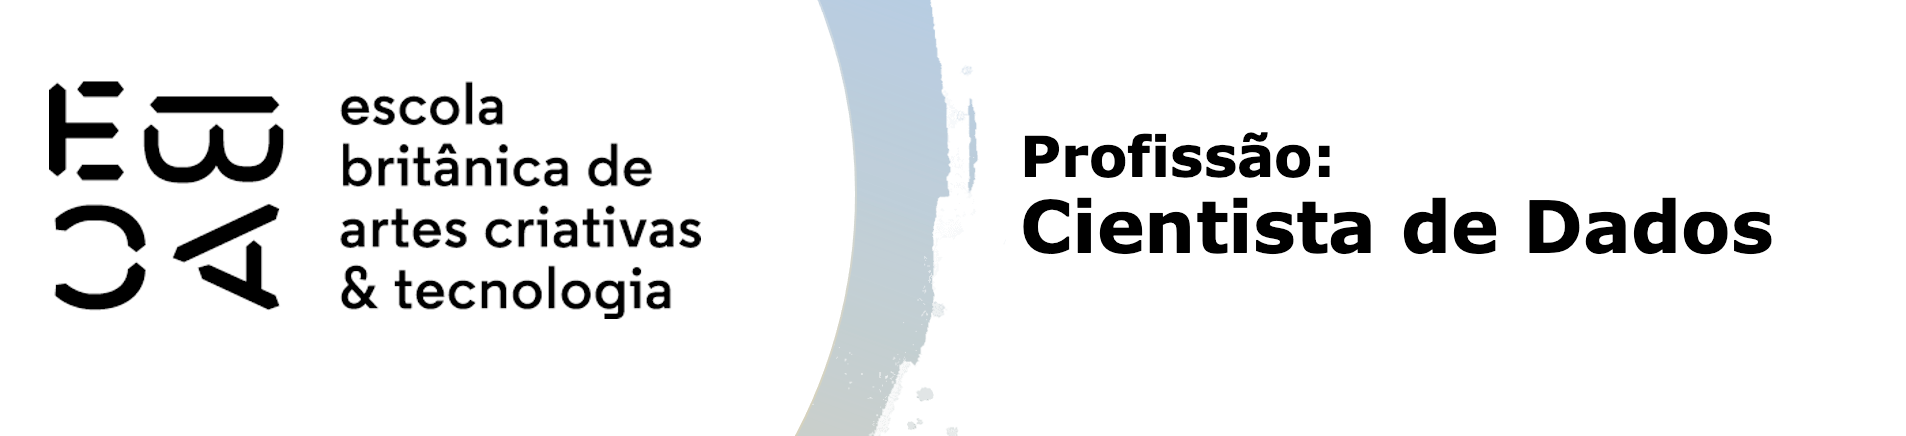

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

Shape do dataset: (86956, 14)
Total de notas: 86956
Notas com retorno > 0: 37318 (42.92%)

TREINANDO MODELOS...
Logistic Regression:
  Acuracia: 0.6006
  ROC AUC: 0.6396

Random Forest:
  Acuracia: 0.5714
  ROC AUC: 0.5948

Gradient Boosting:
  Acuracia: 0.6080
  ROC AUC: 0.6473

MELHOR MODELO: Gradient Boosting

IMPORTANCIA DAS VARIAVEIS:
                  feature  importance
0                Valor NF    0.317595
6        categoria_Varejo    0.282418
3      categoria_Farmácia    0.102903
8  categoria_não definido    0.096232
5  categoria_Restaurantes    0.096034
7     categoria_Vestuário    0.054384
4       categoria_Mercado    0.026689
1    categoria_Auto posto    0.014964
2    categoria_Construção    0.008782


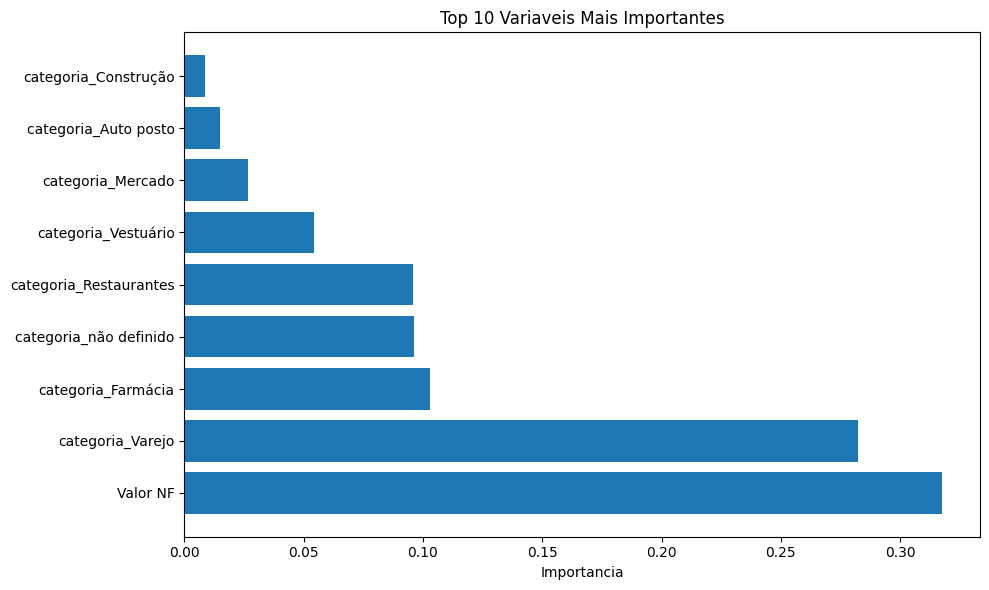

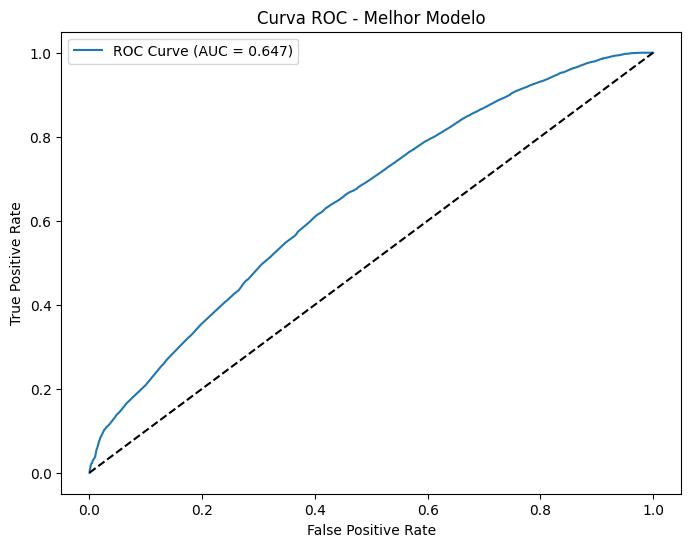


PROPENSAO MEDIA POR CATEGORIA:
Restaurantes: 0.761
Mercado: 0.481
Construção: 0.479
não definido: 0.367
Farmácia: 0.362
Auto posto: 0.324
Vestuário: 0.259
Varejo: 0.143

PROPENSAO POR FAIXA DE VALOR:
(-86.999, 17399.8]: 0.428
(17399.8, 34799.6]: 0.112
(34799.6, 52199.4]: 0.098
(52199.4, 69599.2]: nan
(69599.2, 86999.0]: 0.098

TOP 10 NOTAS COM MAIOR RISCO DE NAO RETORNO:
 Valor NF    categoria  predicted_risk
     1.55 Restaurantes        0.833254
     1.72 Restaurantes        0.833254
     1.65 Restaurantes        0.833254
     1.70 Restaurantes        0.833254
     1.67 Restaurantes        0.833254
     0.67 Restaurantes        0.818533
     0.62 Restaurantes        0.818533
     0.60 Restaurantes        0.818533
     0.67 Restaurantes        0.818533
    23.68 Restaurantes        0.815861


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

df = pd.read_pickle('base_nfp.pkl')

df = df[df['Data Emissão'] >= '2020-01-01']

df['target'] = (df['Retorno'] > 0).astype(int)

print(f"Shape do dataset: {df.shape}")
print(f"Total de notas: {len(df)}")
print(f"Notas com retorno > 0: {df['target'].sum()} ({df['target'].mean()*100:.2f}%)")

features = ['Valor NF', 'categoria']
X = df[features]
y = df['target']

X_encoded = pd.get_dummies(X, columns=['categoria'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
numeric_cols = ['Valor NF']
X_train_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_numeric = scaler.transform(X_test[numeric_cols])

X_train_final = np.column_stack([X_train_numeric, X_train.drop(numeric_cols, axis=1)])
X_test_final = np.column_stack([X_test_numeric, X_test.drop(numeric_cols, axis=1)])

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
}

results = {}

print("\nTREINANDO MODELOS...")
for name, model in models.items():
    model.fit(X_train_final, y_train)
    y_pred = model.predict(X_test_final)
    y_pred_proba = model.predict_proba(X_test_final)[:, 1]
    
    accuracy = np.mean(y_pred == y_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"{name}:")
    print(f"  Acuracia: {accuracy:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print()

best_model_name = max(results.items(), key=lambda x: x[1]['roc_auc'])[0]
best_model = results[best_model_name]['model']

print(f"MELHOR MODELO: {best_model_name}")

if hasattr(best_model, 'feature_importances_'):
    importance = best_model.feature_importances_
elif hasattr(best_model, 'coef_'):
    importance = np.abs(best_model.coef_[0])
else:
    importance = [0] * X_encoded.shape[1]

feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': importance
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nIMPORTANCIA DAS VARIAVEIS:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.title('Top 10 Variaveis Mais Importantes')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

y_pred_proba = results[best_model_name]['y_pred_proba']
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Melhor Modelo')
plt.legend()
plt.show()

df_test = X_test.copy()
df_test['target'] = y_test.values
df_test['predicted_prob'] = y_pred_proba

categoria_cols = [col for col in df_test.columns if col.startswith('categoria_')]
if categoria_cols:
    categoria_propensity = {}
    for col in categoria_cols:
        categoria_name = col.replace('categoria_', '')
        mask = df_test[col] == 1
        if mask.any():
            categoria_propensity[categoria_name] = df_test.loc[mask, 'predicted_prob'].mean()
    
    categoria_propensity = pd.Series(categoria_propensity).sort_values(ascending=False)
    
    print("\nPROPENSAO MEDIA POR CATEGORIA:")
    for categoria, propensity in categoria_propensity.items():
        print(f"{categoria}: {propensity:.3f}")

valor_ranges = pd.cut(df_test['Valor NF'], bins=5)
valor_propensity = df_test.groupby(valor_ranges)['predicted_prob'].mean()

print("\nPROPENSAO POR FAIXA DE VALOR:")
for valor_range, propensity in valor_propensity.items():
    print(f"{valor_range}: {propensity:.3f}")

X_full_encoded = pd.get_dummies(df[features], columns=['categoria'], drop_first=True)
X_full_numeric = scaler.transform(df[['Valor NF']])
X_full_final = np.column_stack([X_full_numeric, X_full_encoded.drop('Valor NF', axis=1)])

df['predicted_risk'] = best_model.predict_proba(X_full_final)[:, 1]

high_risk_notes = df.nlargest(10, 'predicted_risk')[['Valor NF', 'categoria', 'predicted_risk']]

print("\nTOP 10 NOTAS COM MAIOR RISCO DE NAO RETORNO:")
print(high_risk_notes.to_string(index=False))

## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [4]:
import pandas as pd
import numpy as np

df = pd.read_pickle('base_nfp.pkl')

df = df[df['Data Emissão'] >= '2020-01-01']

df['target'] = (df['Retorno'] > 0).astype(int)

df['dia_semana'] = df['Data Emissão'].dt.dayofweek
df['fim_semana'] = df['dia_semana'].isin([5, 6]).astype(int)
df['dia_mes'] = df['Data Emissão'].dt.day
df['trimestre'] = df['Data Emissão'].dt.quarter

df['Valor NF_5cat'] = pd.qcut(df['Valor NF'], q=5, labels=False, duplicates='drop')
df['Valor NF_10cat'] = pd.qcut(df['Valor NF'], q=10, labels=False, duplicates='drop')
df['Valor NF_20cat'] = pd.qcut(df['Valor NF'], q=20, labels=False, duplicates='drop')
df['Valor NF_50cat'] = pd.qcut(df['Valor NF'], q=50, labels=False, duplicates='drop')

print("Variaveis temporais criadas:")
print(f"- Dia da semana: {df['dia_semana'].nunique()} categorias")
print(f"- Fim de semana: {df['fim_semana'].nunique()} categorias") 
print(f"- Dia do mes: {df['dia_mes'].nunique()} categorias")
print(f"- Trimestre: {df['trimestre'].nunique()} categorias")

print("\nCategorizacoes do Valor NF:")
print(f"- 5 categorias: {df['Valor NF_5cat'].nunique()} categorias")
print(f"- 10 categorias: {df['Valor NF_10cat'].nunique()} categorias")
print(f"- 20 categorias: {df['Valor NF_20cat'].nunique()} categorias")
print(f"- 50 categorias: {df['Valor NF_50cat'].nunique()} categorias")

print(f"\nShape final do dataset: {df.shape}")
print("\nColunas disponiveis:")
print(df.columns.tolist())

Variaveis temporais criadas:
- Dia da semana: 7 categorias
- Fim de semana: 2 categorias
- Dia do mes: 31 categorias
- Trimestre: 4 categorias

Categorizacoes do Valor NF:
- 5 categorias: 5 categorias
- 10 categorias: 10 categorias
- 20 categorias: 20 categorias
- 50 categorias: 50 categorias

Shape final do dataset: (86956, 22)

Colunas disponiveis:
['CNPJ emit.', 'Emitente', 'No.', 'Data Emissão', 'Valor NF', 'Data Registro', 'Créditos', 'Situação do Crédito', 'Ano', 'Semestre', 'Retorno', 'flag_credito', 'categoria', 'target', 'dia_semana', 'fim_semana', 'dia_mes', 'trimestre', 'Valor NF_5cat', 'Valor NF_10cat', 'Valor NF_20cat', 'Valor NF_50cat']


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [6]:
import pandas as pd
import numpy as np

df = pd.read_pickle('base_nfp.pkl')
df = df[df['Data Emissão'] >= '2020-01-01']
df['target'] = (df['Retorno'] > 0).astype(int)

df['dia_semana'] = df['Data Emissão'].dt.dayofweek
df['fim_semana'] = df['dia_semana'].isin([5, 6]).astype(int)
df['dia_mes'] = df['Data Emissão'].dt.day
df['trimestre'] = df['Data Emissão'].dt.quarter

df['Valor NF_5cat'] = pd.qcut(df['Valor NF'], q=5, labels=False, duplicates='drop')
df['Valor NF_10cat'] = pd.qcut(df['Valor NF'], q=10, labels=False, duplicates='drop')
df['Valor NF_20cat'] = pd.qcut(df['Valor NF'], q=20, labels=False, duplicates='drop')
df['Valor NF_50cat'] = pd.qcut(df['Valor NF'], q=50, labels=False, duplicates='drop')

def calculate_iv(df, variable, target):
    temp_df = df[[variable, target]].copy()
    temp_df[variable] = temp_df[variable].fillna('MISSING')
    
    woe_df = temp_df.groupby(variable)[target].agg([
        ('total', 'count'),
        ('eventos', lambda x: (x == 1).sum()),
        ('nao_eventos', lambda x: (x == 0).sum())
    ]).reset_index()
    
    total_eventos = woe_df['eventos'].sum()
    total_nao_eventos = woe_df['nao_eventos'].sum()
    
    if total_eventos == 0 or total_nao_eventos == 0:
        return 0.0
    
    woe_df['pct_eventos'] = woe_df['eventos'] / total_eventos
    woe_df['pct_nao_eventos'] = woe_df['nao_eventos'] / total_nao_eventos
    
    woe_df['WOE'] = np.log(woe_df['pct_eventos'] / woe_df['pct_nao_eventos'])
    woe_df['WOE'] = woe_df['WOE'].replace([np.inf, -np.inf], 0)
    
    woe_df['IV'] = (woe_df['pct_eventos'] - woe_df['pct_nao_eventos']) * woe_df['WOE']
    
    return woe_df['IV'].sum()

variables_to_test = [
    'categoria', 'Valor NF', 'dia_semana', 'fim_semana', 
    'dia_mes', 'trimestre', 'Ano', 'Semestre',
    'Valor NF_5cat', 'Valor NF_10cat', 'Valor NF_20cat', 'Valor NF_50cat'
]

metadata = []
for variable in variables_to_test:
    try:
        iv = calculate_iv(df, variable, 'target')
        metadata.append({
            'Variavel': variable,
            'IV': iv,
            'Tipo': 'Categorica' if variable != 'Valor NF' else 'Numerica',
            'Categorias': df[variable].nunique() if variable != 'Valor NF' else 'Continua'
        })
    except Exception as e:
        print(f"Erro ao calcular IV para {variable}: {e}")
        continue

iv_results = pd.DataFrame(metadata)
iv_results = iv_results.sort_values('IV', ascending=False)

def interpret_iv(iv):
    if iv < 0.02: return 'Sem poder preditivo'
    elif iv < 0.1: return 'Poder preditivo fraco'
    elif iv < 0.3: return 'Poder preditivo medio'
    elif iv < 0.5: return 'Poder preditivo forte'
    else: return 'Poder preditivo muito forte'

iv_results['Interpretacao'] = iv_results['IV'].apply(interpret_iv)

print("INFORMATION VALUE (IV) POR VARIAVEL")
print("=" * 80)
print(iv_results.to_string(index=False))
print("=" * 80)

print("\nRESUMO ESTATISTICO:")
print(f"Total de variaveis analisadas: {len(iv_results)}")
print(f"Variavel com maior IV: {iv_results.iloc[0]['Variavel']} ({iv_results.iloc[0]['IV']:.6f})")
print(f"Variavel com menor IV: {iv_results.iloc[-1]['Variavel']} ({iv_results.iloc[-1]['IV']:.6f})")
print(f"IV medio: {iv_results['IV'].mean():.6f}")

strong_predictors = iv_results[iv_results['IV'] >= 0.1]
print(f"\nVariaveis com poder preditivo medio ou forte (IV >= 0.1): {len(strong_predictors)}")
for _, row in strong_predictors.iterrows():
    print(f"  {row['Variavel']}: {row['IV']:.6f} ({row['Interpretacao']})")

INFORMATION VALUE (IV) POR VARIAVEL
      Variavel       IV       Tipo Categorias         Interpretacao
      Valor NF 0.404500   Numerica   Continua Poder preditivo forte
     categoria 0.278826 Categorica          9 Poder preditivo medio
Valor NF_50cat 0.122257 Categorica         50 Poder preditivo medio
Valor NF_20cat 0.078348 Categorica         20 Poder preditivo fraco
Valor NF_10cat 0.059107 Categorica         10 Poder preditivo fraco
 Valor NF_5cat 0.038990 Categorica          5 Poder preditivo fraco
       dia_mes 0.015128 Categorica         31   Sem poder preditivo
    dia_semana 0.005878 Categorica          7   Sem poder preditivo
      Semestre 0.004874 Categorica          2   Sem poder preditivo
    fim_semana 0.004599 Categorica          2   Sem poder preditivo
     trimestre 0.003554 Categorica          4   Sem poder preditivo
           Ano 0.003168 Categorica          3   Sem poder preditivo

RESUMO ESTATISTICO:
Total de variaveis analisadas: 12
Variavel com maior IV: Va

## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

Variáveis com maior poder discriminatório (IV):

Valor NF (IV = 0.405) - Poder preditivo forte

categoria (IV = 0.279) - Poder preditivo médio

Valor NF_50cat (IV = 0.122) - Poder preditivo médio

Relação entre categorização e IV:
Sim, há relação direta. Quanto mais categorias (maior granularidade), maior o IV:

Valor NF_5cat (5 categorias): IV = 0.039

Valor NF_10cat (10 categorias): IV = 0.059

Valor NF_20cat (20 categorias): IV = 0.078

Valor NF_50cat (50 categorias): IV = 0.122

Conclusão: Variáveis contínuas categorizadas com maior granularidade capturam melhor a relação com o target, porém a variável original contínua ("Valor NF") mantém o melhor poder preditivo.

New chat


## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

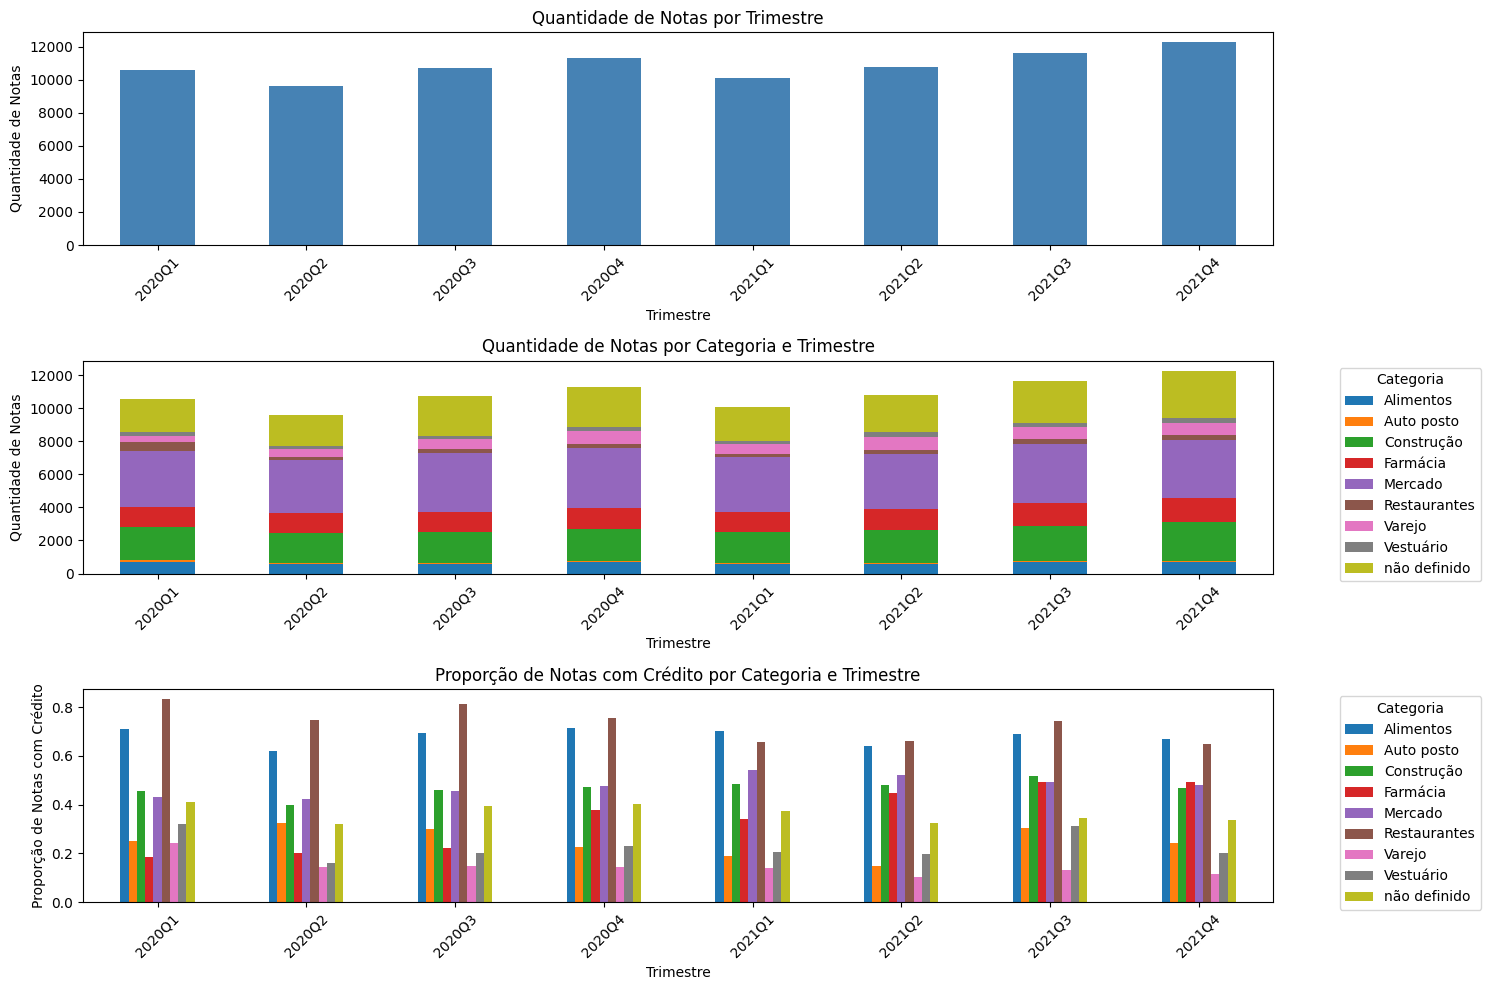

Resumo por Trimestre:
2020Q1: 10584 notas
2020Q2: 9610 notas
2020Q3: 10716 notas
2020Q4: 11302 notas
2021Q1: 10083 notas
2021Q2: 10788 notas
2021Q3: 11622 notas
2021Q4: 12251 notas

Evolução da Proporção de Crédito:
Alimentos: 0.680 (média trimestral)
Auto posto: 0.247 (média trimestral)
Construção: 0.468 (média trimestral)
Farmácia: 0.345 (média trimestral)
Mercado: 0.478 (média trimestral)
Restaurantes: 0.733 (média trimestral)
Varejo: 0.145 (média trimestral)
Vestuário: 0.228 (média trimestral)
não definido: 0.364 (média trimestral)


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_pickle('base_nfp.pkl')
df = df[df['Data Emissão'] >= '2020-01-01']

df['trimestre'] = df['Data Emissão'].dt.to_period('Q')
df['com_credito'] = (df['Retorno'] > 0).astype(int)

notas_por_trimestre = df.groupby('trimestre').size()
notas_por_categoria_trimestre = df.groupby(['trimestre', 'categoria']).size().unstack(fill_value=0)
proporcao_credito_trimestre = df.groupby(['trimestre', 'categoria'])['com_credito'].mean().unstack(fill_value=0)

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
notas_por_trimestre.plot(kind='bar', color='steelblue')
plt.title('Quantidade de Notas por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.xticks(rotation=45)

plt.subplot(3, 1, 2)
notas_por_categoria_trimestre.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Quantidade de Notas por Categoria e Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

plt.subplot(3, 1, 3)
proporcao_credito_trimestre.plot(kind='bar', ax=plt.gca())
plt.title('Proporção de Notas com Crédito por Categoria e Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Proporção de Notas com Crédito')
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Resumo por Trimestre:")
print("=" * 50)
for trimestre in notas_por_trimestre.index:
    total_notas = notas_por_trimestre[trimestre]
    print(f"{trimestre}: {total_notas} notas")
    
print("\nEvolução da Proporção de Crédito:")
print("=" * 50)
for categoria in proporcao_credito_trimestre.columns:
    evolucao = proporcao_credito_trimestre[categoria]
    print(f"{categoria}: {evolucao.mean():.3f} (média trimestral)")

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

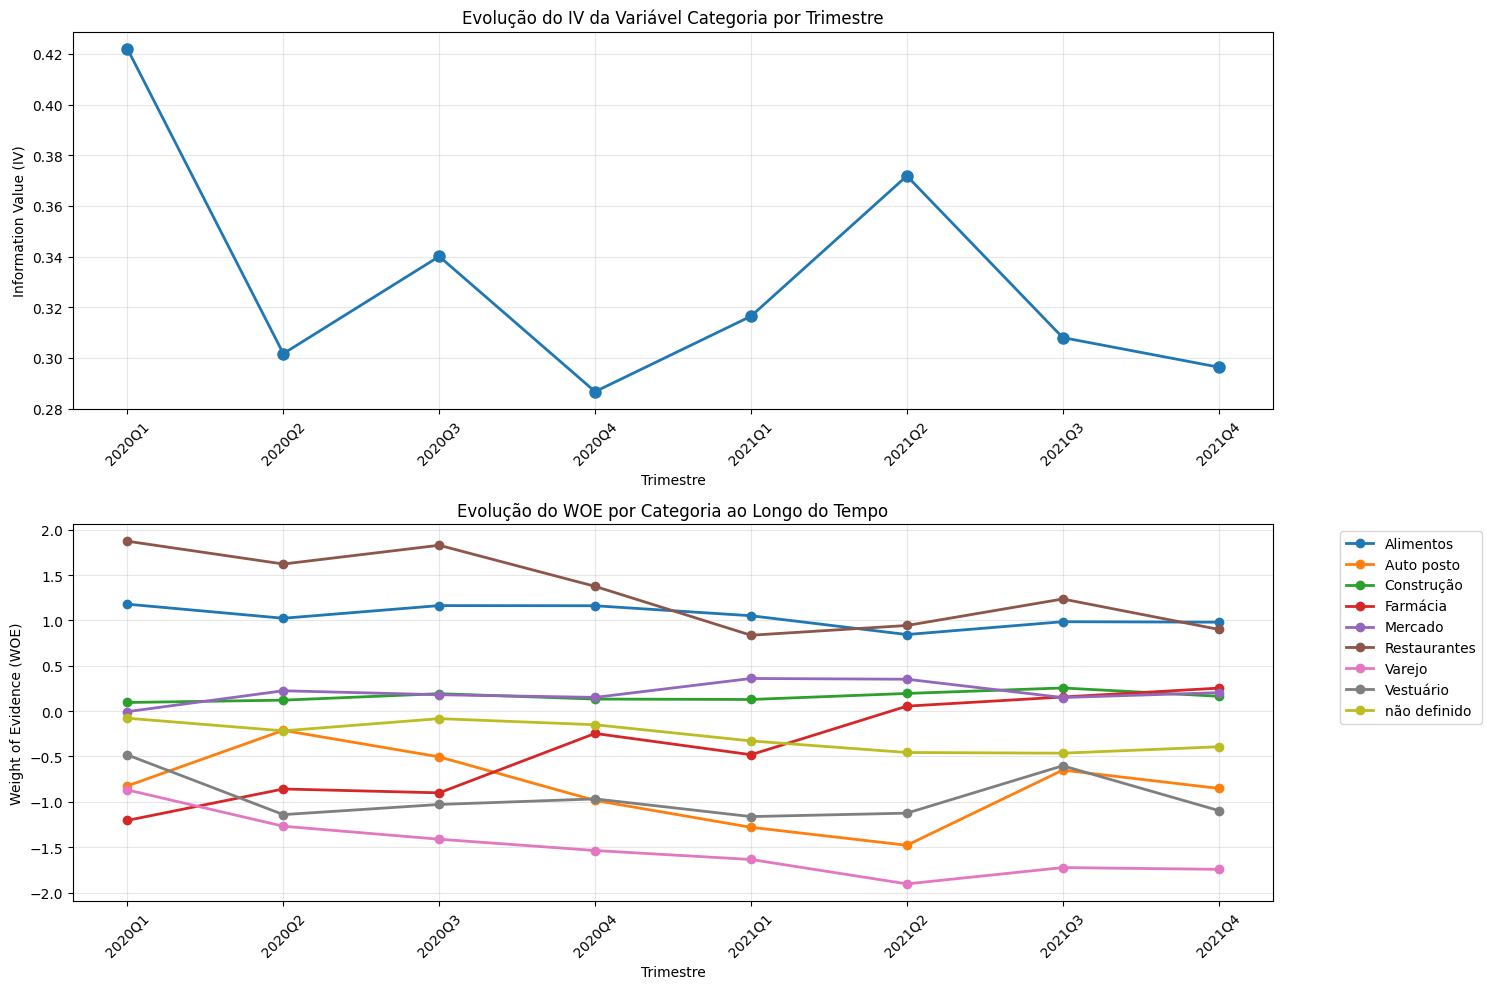

EVOLUÇÃO DO IV POR TRIMESTRE:
2020Q1: IV = 0.421986
2020Q2: IV = 0.301671
2020Q3: IV = 0.340058
2020Q4: IV = 0.286660
2021Q1: IV = 0.316451
2021Q2: IV = 0.371846
2021Q3: IV = 0.308010
2021Q4: IV = 0.296336

IV MÉDIO: 0.330377
MAIOR IV: 0.421986 (2020Q1)
MENOR IV: 0.286660 (2020Q4)

ESTABILIDADE DO WOE (Desvio Padrão):
Construção: 0.0485
Alimentos: 0.1084
Mercado: 0.1099
não definido: 0.1499
Vestuário: 0.2447
Varejo: 0.3066
Auto posto: 0.3819
Restaurantes: 0.3898
Farmácia: 0.5100


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_pickle('base_nfp.pkl')
df = df[df['Data Emissão'] >= '2020-01-01']
df['trimestre'] = df['Data Emissão'].dt.to_period('Q')
df['target'] = (df['Retorno'] > 0).astype(int)

def calculate_woe_iv(df, variable, target):
    temp_df = df[[variable, target]].copy()
    temp_df[variable] = temp_df[variable].fillna('MISSING')
    
    woe_df = temp_df.groupby(variable)[target].agg([
        ('total', 'count'),
        ('eventos', lambda x: (x == 1).sum()),
        ('nao_eventos', lambda x: (x == 0).sum())
    ]).reset_index()
    
    total_eventos = woe_df['eventos'].sum()
    total_nao_eventos = woe_df['nao_eventos'].sum()
    
    if total_eventos == 0 or total_nao_eventos == 0:
        return pd.Series(), 0.0
    
    woe_df['pct_eventos'] = woe_df['eventos'] / total_eventos
    woe_df['pct_nao_eventos'] = woe_df['nao_eventos'] / total_nao_eventos
    
    woe_df['WOE'] = np.log(woe_df['pct_eventos'] / woe_df['pct_nao_eventos'])
    woe_df['WOE'] = woe_df['WOE'].replace([np.inf, -np.inf], 0)
    
    woe_df['IV'] = (woe_df['pct_eventos'] - woe_df['pct_nao_eventos']) * woe_df['WOE']
    
    woe_series = woe_df.set_index(variable)['WOE']
    iv_total = woe_df['IV'].sum()
    
    return woe_series, iv_total

trimestres = sorted(df['trimestre'].unique())
trimestres_str = [str(t) for t in trimestres]

resultados_iv = []
woe_evolucao = {}

for trimestre in trimestres:
    df_trimestre = df[df['trimestre'] == trimestre]
    woe_series, iv_total = calculate_woe_iv(df_trimestre, 'categoria', 'target')
    
    resultados_iv.append({
        'Trimestre': trimestre,
        'IV': iv_total
    })
    
    for categoria, woe_value in woe_series.items():
        if categoria not in woe_evolucao:
            woe_evolucao[categoria] = []
        woe_evolucao[categoria].append(woe_value)

resultados_iv_df = pd.DataFrame(resultados_iv)

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(trimestres_str, resultados_iv_df['IV'], marker='o', linewidth=2, markersize=8)
plt.title('Evolução do IV da Variável Categoria por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Information Value (IV)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
for categoria, woe_values in woe_evolucao.items():
    plt.plot(trimestres_str, woe_values, marker='o', label=categoria, linewidth=2, markersize=6)

plt.title('Evolução do WOE por Categoria ao Longo do Tempo')
plt.xlabel('Trimestre')
plt.ylabel('Weight of Evidence (WOE)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("EVOLUÇÃO DO IV POR TRIMESTRE:")
print("=" * 40)
for _, row in resultados_iv_df.iterrows():
    print(f"{row['Trimestre']}: IV = {row['IV']:.6f}")

print(f"\nIV MÉDIO: {resultados_iv_df['IV'].mean():.6f}")
print(f"MAIOR IV: {resultados_iv_df['IV'].max():.6f} ({resultados_iv_df.loc[resultados_iv_df['IV'].idxmax(), 'Trimestre']})")
print(f"MENOR IV: {resultados_iv_df['IV'].min():.6f} ({resultados_iv_df.loc[resultados_iv_df['IV'].idxmin(), 'Trimestre']})")

woe_estabilidade = {}
for categoria, woe_values in woe_evolucao.items():
    woe_estabilidade[categoria] = np.std(woe_values)

print(f"\nESTABILIDADE DO WOE (Desvio Padrão):")
for categoria, std in sorted(woe_estabilidade.items(), key=lambda x: x[1]):
    print(f"{categoria}: {std:.4f}")

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

Categorias com maior retorno positivo:

Restaurantes e Alimentos lideram com maior propensão a retornos >0

Mercado e Construção apresentam proporção moderada-alta

Varejo mostra menor propensão a retornos positivos

Estabilidade temporal:

IV médio de 0.330 indica poder preditivo médio estável

Maior IV em 2020Q1 (0.422), menor em 2020Q4 (0.287)

Categorias essenciais (Construção, Alimentos, Mercado) mais estáveis

Categorias como Farmácia e Restaurantes com maior volatilidade

Conclusão:
As diferenças entre categorias são relativamente estáveis, com padrões consistentes apesar do crescimento no volume de notas e dos impactos da pandemia. Restaurantes e Alimentos mantêm-se como categorias de maior risco, enquanto Varejo permanece com menor propensão a retornos positivos.

New chat
